# Introduction: Time Series Analysis and Forecasting Project

**Dataset**

The data have been downloaded from the website https://www.visualcrossing.com/weather/weather-data-services. The data are average daily temperatures collected in Tampa, Florida, USA from December 9th,2016 to December 9th, 2021 (5 years period)

If you want more info about this project, check out the article I wrote about it. 

# Exploratory Data Analysis

**Explore dataset**


In [6]:
# Change to the data directory
import os
os.chdir(r'C:\Users\nguye\Desktop\Data Science Stuff\Projects\GIS\Time_Series_Analysis\Weather_Tampa') # You should change to the corresponding directory in your computer 
os.listdir()

['Tampa, Florida 2016-12-01 to 2021-12-01.csv',
 'Tampa, Florida 2016-12-01 to 2021-12-01.xlsx',
 'weather_tampa.csv']

In [55]:
# Import libraries
import numpy as np
import pandas as pd

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the data
weather_data = pd.read_csv('weather_tampa.csv')
#Change datetime to date
weather_data['date'] = pd.to_datetime(weather_data['datetime'], format='%m/%d/%Y')
# Check the shape of the dataset
print(weather_data.shape)

# Select the datetime and the temperature columns
temp_df = weather_data[["date","T"]]
print(temp_df.head(10))
print(temp_df.info())

(1827, 33)
        date     T
0 2016-12-01  23.0
1 2016-12-02  18.7
2 2016-12-03  19.5
3 2016-12-04  22.6
4 2016-12-05  24.2
5 2016-12-06  23.9
6 2016-12-07  20.3
7 2016-12-08  16.8
8 2016-12-09  13.7
9 2016-12-10  15.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1827 non-null   datetime64[ns]
 1   T       1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB
None


**Dataset Explanation**


In [56]:
# Select data from 2016 to 2021
mask = (temp_df['date'] >= '2016-01-01') & (temp_df['date'] <= '2021-12-01')
temp_df = temp_df.loc[mask]

# Reset the index 
temp_df.set_index("date", inplace=True)

# Inspect first 5 rows and last 5 rows of the data
from IPython.display import display
display(temp_df.head(5))
display(temp_df.tail(5))

,T
date,
2016-12-01,23.0
2016-12-02,18.7
2016-12-03,19.5
2016-12-04,22.6
2016-12-05,24.2


,T
date,
2021-11-27,15.2
2021-11-28,15.5
2021-11-29,16.6
2021-11-30,14.6
2021-12-01,17.6


For simplicity, the T column above shows the daily average temperatures for the first 5 days of January 2017 and last 5 days from November 27th to December 1st, 2021 in in Tampa, FL

In order to get more information, Python Pandas library provides a 'describe' function to show the count, mean, standard deviation, min/ max value and the quantiles of our dataset:

In [57]:
print( temp_df.describe())

# Output the maximum and minimum temperature date
print(temp_df.loc[temp_df["T"] == temp_df["T"].max()])
print(temp_df.loc[temp_df["T"] == temp_df["T"].min()])

                T
count  1827.00000
mean     23.58046
std       4.92990
min       4.50000
25%      20.60000
50%      24.90000
75%      27.60000
max      31.20000
               T
date            
2019-06-26  31.2
              T
date           
2018-01-18  4.5


**Observations**:

On June 26th, 2019, Tampa witnessed the hottest date in the 5-year period (2016-2021). The temperature was 31.2 degrees Celsius. In contrast, on January 18th, 2018, Tampa citizens saw the coldest date in the 5-year period, when the temperature dropped to  4.5 degrees Celsius.
There was not a significant difference between the median and the mean, being approximately 23.63 and 25 degrees Celsius respectively.

# Data Visualization
Let’s explore this time series as a data visualization:

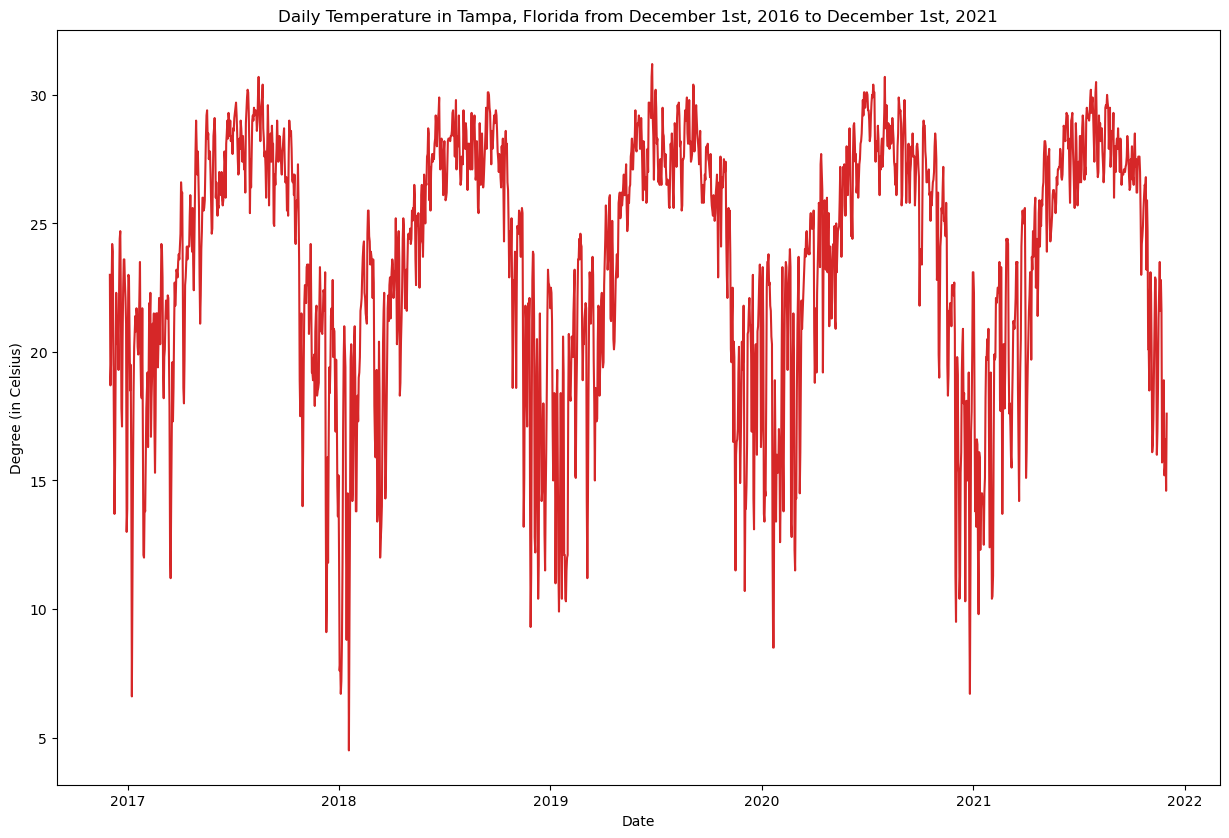

In [58]:
# Plot the daily temperature change 
plt.figure(figsize=(15,10), dpi=100)
plt.plot(temp_df.index, temp_df['T'], color='tab:red')
plt.gca().set(title="Daily Temperature in Tampa, Florida from December 1st, 2016 to December 1st, 2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

The figure above shows the average daily temperature in Tampa, Florida from December 1st, 2016 to December 1st, 2021.

However, the plot above is a bit noisy, because it contains all the daily temperatures.

**How could we plot the graph containing only longer-than-daily temperature change and thus looks neater?**

Here is the tool: The moving average is mostly used with time series data to capture the short-term fluctuations while focusing on longer trends.

<AxesSubplot:xlabel='date'>

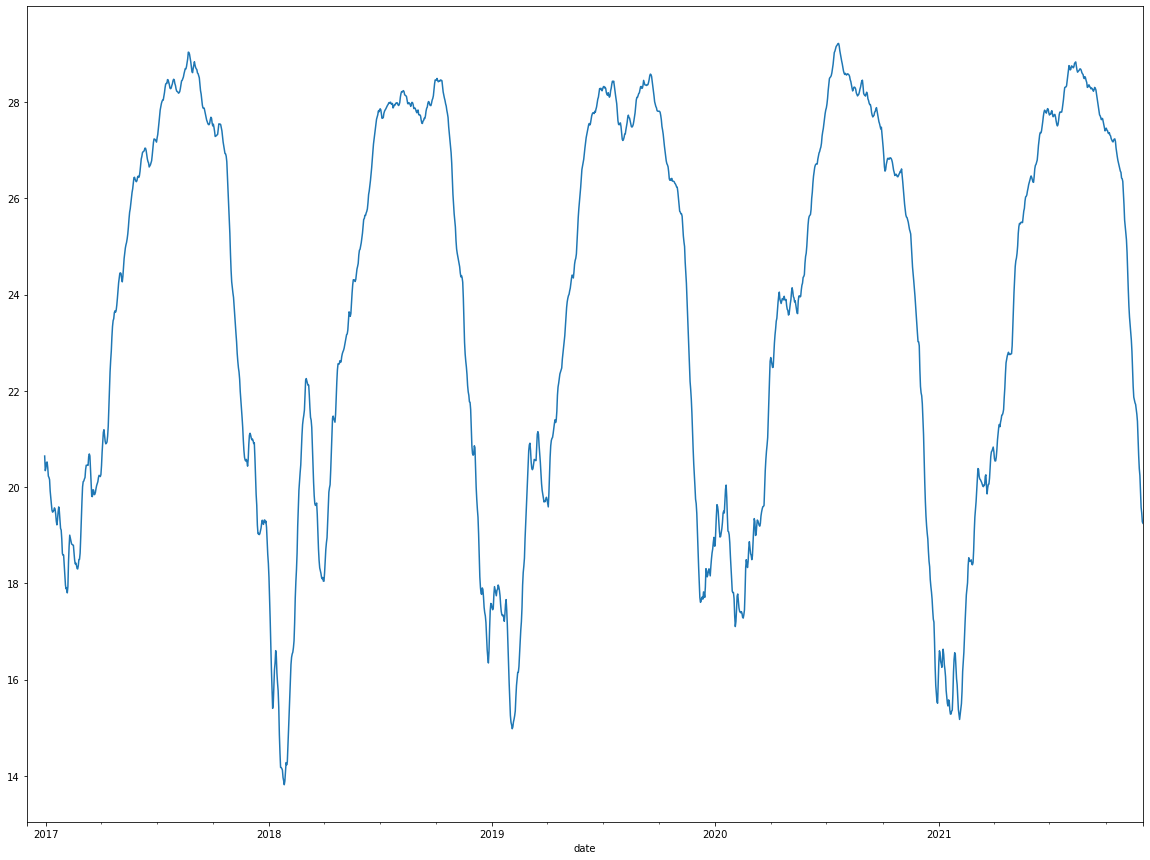

In [59]:
# Apply the Moving Average function by a subset of size 30 days.
temp_df_mean = temp_df['T'].rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as temperatures are always low at the beginning of the year and high at the middle of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.


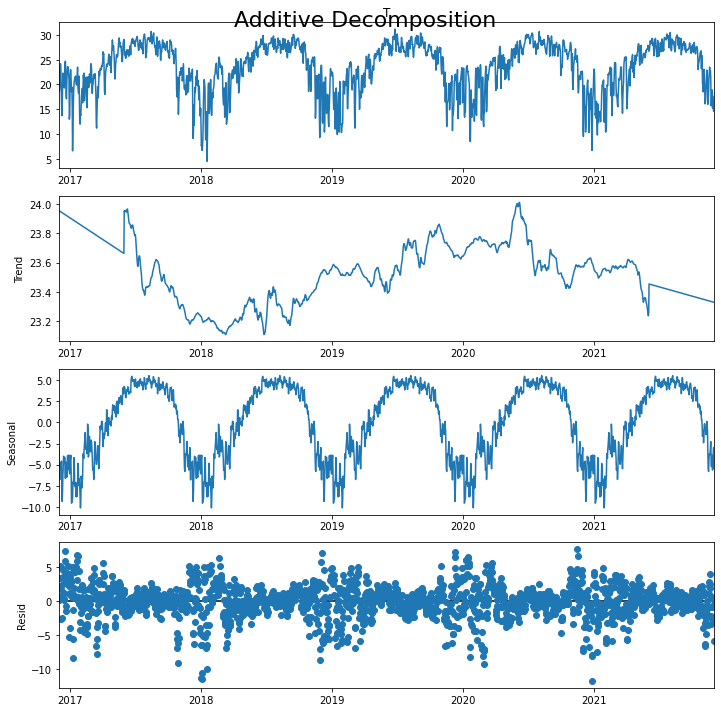

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(temp_df['T'], model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

The plot above clearly shows that the temperature is unstable, along with its obvious seasonality.

# Baseline Model

Since the change of temperature is not significant between 2 days, it is reasonable to produce a most basic model in which it uses the current temperature as a prediction for the next day.

**Thus, we would predict the weather based on an assumption**: The air temperature today depends on the air temperature yesterday, the air temperature yesterday depends on the day before yesterday, and so on.

Here, I use 1-step prediction to model the temperature as a time series:



In [61]:
# Shift the current temperature to the next day. 
predicted_df = temp_df["T"].to_frame().shift(1).rename(columns = {"T": "T_pred" })
actual_df = temp_df["T"].to_frame().rename(columns = {"T": "T_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,T_actual,T_pred
date,,
2016-12-02,18.7,23.0
2016-12-03,19.5,18.7
2016-12-04,22.6,19.5
2016-12-05,24.2,22.6
2016-12-06,23.9,24.2
2016-12-07,20.3,23.9
2016-12-08,16.8,20.3
2016-12-09,13.7,16.8
2016-12-10,15.6,13.7


We could validate how well our model is by looking at the Root Mean Squared Error(RMSE) between the predicted and actual temperature:



In [62]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.T_actual, one_step_df.T_pred, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 1.9823343580535011


The RMSE is small, meaning that we can use the most basic 1-step prediction baseline model to predict the upcoming day's temperature with the average error of only around 1.96 degrees Celsius. The error is acceptable, especially in the Weather Forecast field in which there are many other attributes that also affect the weather (e.g wind speed, atmospheric pressure, humidity, etc).

Another widely-used technique for time series prediction is SARIMA Model. I would like to see if it is possible to lower the prediction error (although it is already really small and totally okay to use it with small tolerance).

# Weather Forecast using SARIMA model

## Parameter Selection

**Grid Search**

We are going to apply one of the most commonly used method for time-series forecasting, known as SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average. SARIMA models are denoted with the notation SARIMA(p,d,q)(P,D,Q,s). These three parameters account for seasonality, trend, and noise in data:

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal SARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [63]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0,1)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (1, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 0, 1, 12)


The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [70]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

In [71]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.T_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue
            

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:16795.171759245764
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:14683.94217673174
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:13293.89250202387
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10059.915353715003
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9761.80207821376
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:9697.722740645404
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:9742.375152855631
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:9703.750136669107
SARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:9684.64644768627
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:14407.051250452361
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12501.407685263397
SARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:11351.555384103172
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:8787.609257442415
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8806.742457947345
SARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:8335.692023349704
SARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:8407.173768205841
SARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:8435.000567697909
SARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:8319.03

The output of our code suggests that SARIMA(1, 0, 1)x(1, 1, 1, 12) yields the lowest AIC value of 7425.82 We should therefore consider this to be optimal option out of all the models we have considered.

SARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:7033.953160617186
SARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:7209.626570064769



**Fitting the Model**


In [72]:
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.T_actual,
                                order=(2, 0, 2),
                                seasonal_order=(2, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()



print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                            T_actual   No. Observations:                 1826
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 12)   Log Likelihood               -3597.813
Date:                             Fri, 10 Dec 2021   AIC                           7209.627
Time:                                     10:36:34   BIC                           7248.095
Sample:                                 12-02-2016   HQIC                          7223.827
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5098      0.031     48.811      0.000       1.449       1.570
ar.L2         -0.5100      

**Model Diagnostics**

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior:

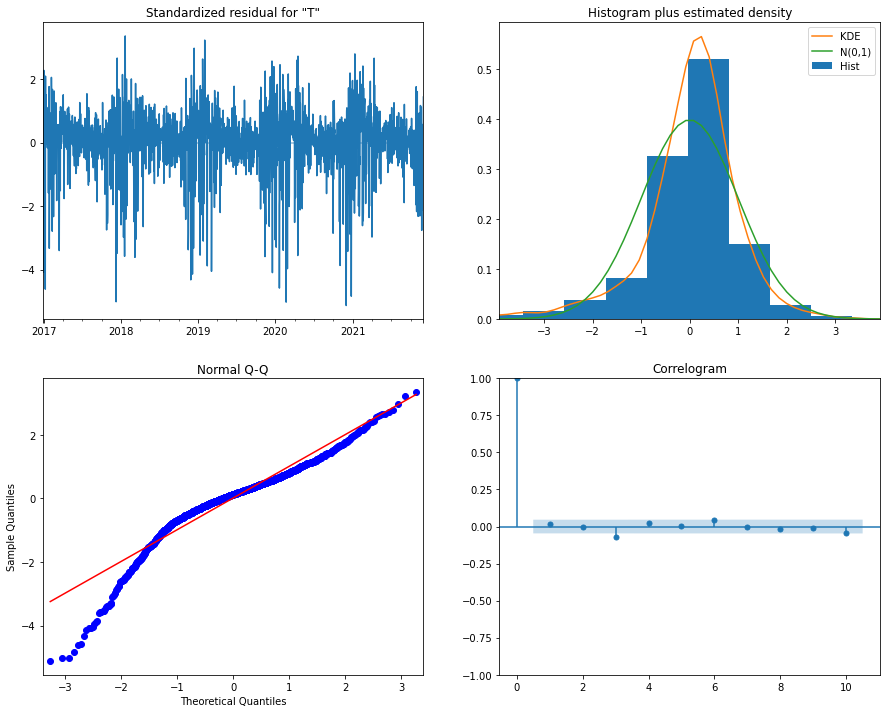

In [73]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
The residuals over time (top left plot) do not display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

In [27]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           T_actual   No. Observations:                 1795
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -3620.305
Date:                            Fri, 10 Dec 2021   AIC                           7250.609
Time:                                    08:55:26   BIC                           7278.000
Sample:                                01-02-2017   HQIC                          7260.729
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8605      0.012     70.783      0.000       0.837       0.884
ma.L1          0.3192      0.021   

## Validating the Non-Dynamic Forecast

The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.




In [74]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at Jannuary 2020.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the average daily temperature to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

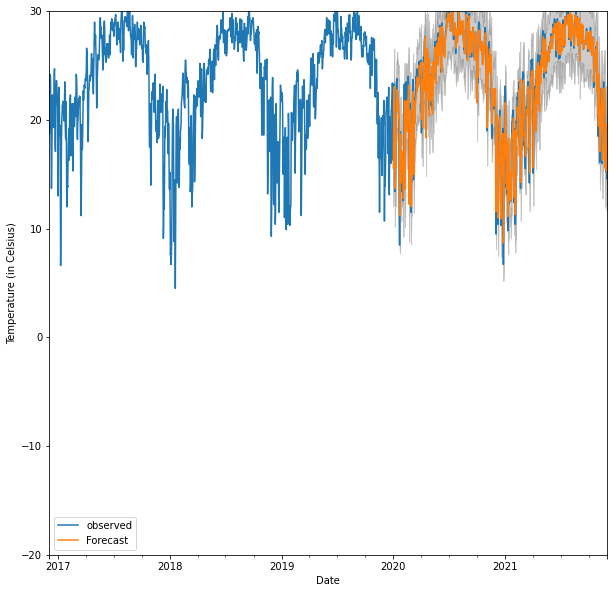

In [75]:


ax = one_step_df.T_actual['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

Overall, our forecasts align with the true values very well, showing a seasonal cycle of length 365 days.



**Forecast Diagnostic**

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), in which for each predicted value, we compute its distance to the true value and square the result.

In [76]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_actual['2020-01-01':]
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.27


Our forecast model forecasts the temperature with only an error of 3.84 degrees Celsius.

In the weather forecast field, the prediction error of 2.19 degrees seems promising and sufficient, as there are many other factors that contribute to the change in temperature, including but not limited to the wind speed, the air pressure, etc.

## Validating the Dynamic Forecast


In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from Jannuary 2016 onwards.

In [77]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

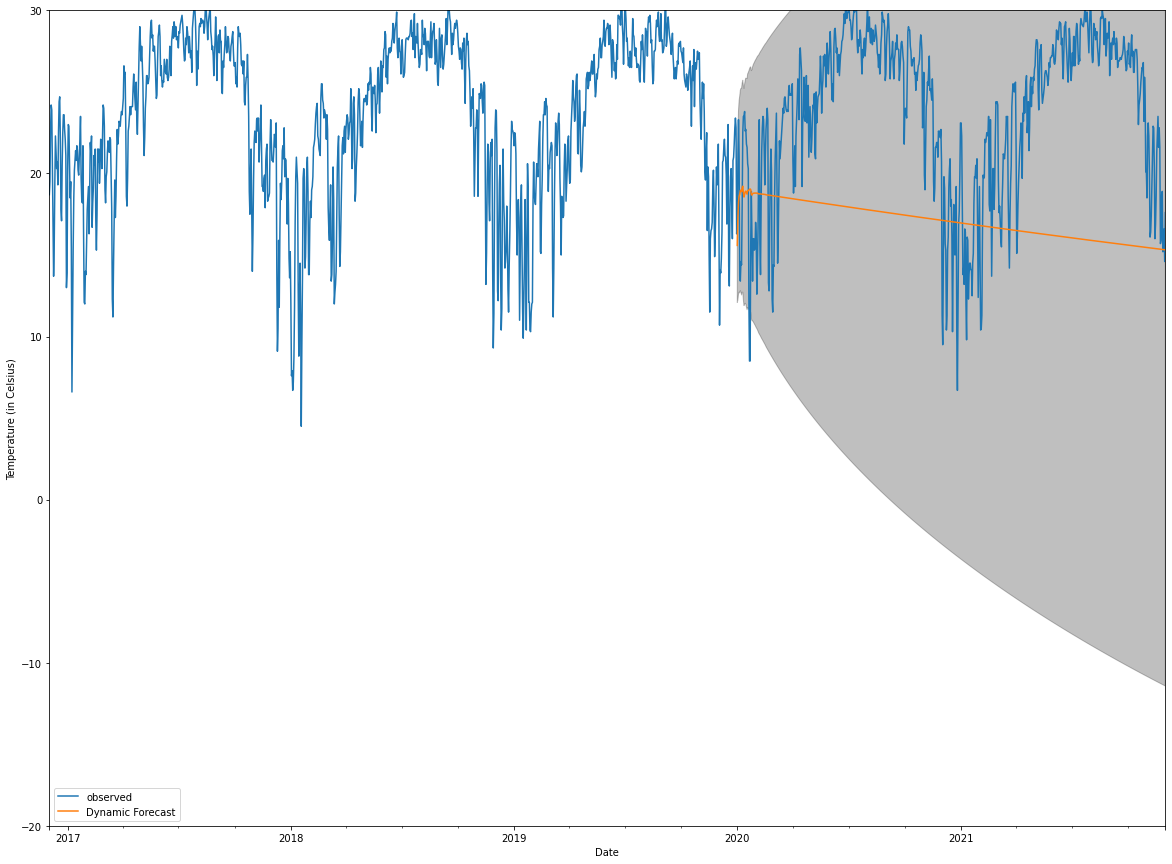

In [78]:
ax = one_step_df.T_actual['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In this case, the model seems to predict the temperature inaccurately, with major fluctuations between the true value and the predicted value.



**Forecast Diagnostic**


In [45]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.T_actual['2020-01-01':]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 11.55


The predicted values obtained from the dynamic forecasts yield an MSE of 11.55. This is significantly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

# Conclusion

In this tutorial, we described how to implement a seasonal SARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the temperature.

Recall that in the assumption we made in the section 1.96 Baseline Model, we could even reinforce our assumption and continue our belief that the air temperature today depends on the air temperature yesterday, the air temperature yesterday depends on the day before yesterday, and so on.

It is the best so far to use the history up to the point that we would like to make predictions on. Especially it holds for weather forecasting, where the temperature today does not change much from yesterday, and the transition to another season signaling through the temperature should gradually occur, unless there is any disastrous factors such as storm, drought, etc.

# Test New Different Way

Autoregressive Integrated Moving Averages

The general process is as follows:

Visualize the time series data
Make the time series data stationary
Plot the Correlation and Autocorrelation charts
Use the model to make predictions

In [64]:
temp_df.head(n=10)

,T
date,
2016-12-01,23.0
2016-12-02,18.7
2016-12-03,19.5
2016-12-04,22.6
2016-12-05,24.2
2016-12-06,23.9
2016-12-07,20.3
2016-12-08,16.8
2016-12-09,13.7


In [65]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(temp_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#lower than 0.05, so we can reject the null hypothesis, and there is no need for differencing.
# Can set d=0 because it is stationary.

ADF Statistic: -2.923027
p-value: 0.042735


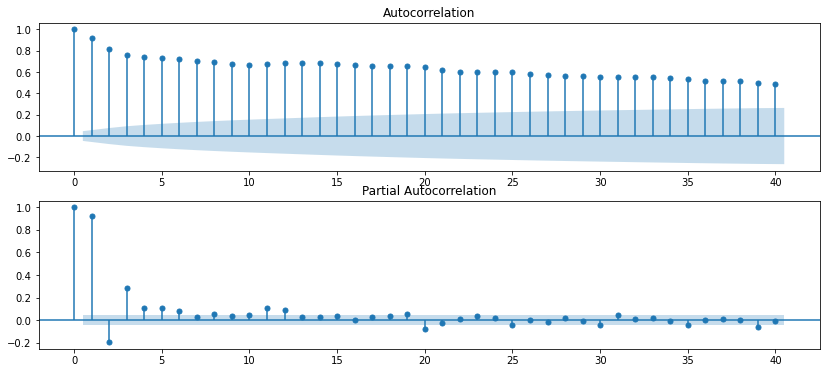

In [66]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_df['T'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_df['T'].dropna(),lags=40,ax=ax2)

In [69]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(temp_df['T'], order=(2,0,1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      T   No. Observations:                 1827
Model:                     ARMA(2, 1)   Log Likelihood               -3736.959
Method:                       css-mle   S.D. of innovations              1.870
Date:                Fri, 10 Dec 2021   AIC                           7483.918
Time:                        10:29:35   BIC                           7511.470
Sample:                    12-01-2016   HQIC                          7494.080
                         - 12-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.5602      0.476     49.532      0.000      22.628      24.492
ar.L1.T        0.6547      0.056     11.616      0.000       0.544       0.765
ar.L2.T        0.2064      0.054      3.851      0.0